In [36]:
from Bio import Entrez
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Entrez.email = "lma@uams.edu"

"""
The example is the FASTA file from GenBank.
"""
with Entrez.efetch (
    db = 'nucleotide', rettype = 'gb', retmode = 'text', id = 'NC_012920.1'
) as handle:
    seq_record = SeqIO.read(handle, 'gb') # using 'gb' as an alias for 'genbank'
    
print('%s with %i features' % (seq_record.id, len(seq_record.features)))

NC_012920.1 with 77 features


In [32]:
"""
For drawing the Chaos Game Representation, we have to count the occurences of k-mers
Thus, the function count_kmers has been created for the task
"""
def count_kmers(seq, k):
    """
    This function performs the k-mer counting task
    Input:
        @seq: a string, which is the genome sequence
        @k: the length of the k-mer, must be an integer no less than 0
    Retrun a dictionary, with the keys being the substrings, the values being the occurences
    """
    if (seq is None or len(seq) == 0) or k <= 0:
        raise ValueError('Invalid sequence or k value')    # This if checks if invalid inputs are give
        
    d = {}  # Define a dictionary named 'd' for storing the k-mers and their occurences
    
    for index in range(len(seq) - k + 1):   # The upper limit of index for counting k-mers is len(seq) - k + 1
        kmer = seq[index : index + k]
        # print(kmer)
        if kmer not in d:
            d[kmer] = 1
        else:
            d[kmer] += 1                        # Storing the current k-mer
        
    for key in d.keys():                    # Removing 'N's
        if 'N' == key:
            del d[key]
            
    return d

"""
Once the k-mers have been counted, we have to count the probability of occurrences of the k-mers
"""
def probability(kmers, k):
    """
    The function probability is defined for calculating the probabilities of occurrences of the kmers
    Input:
        @kmers: a dictionary returned from count_kmers object defeined previous
        @k: the length of k
    Return:
        a dictionary with the keys being the substring, the values being the probability of that substring
    """
    if type(kmers) is not dict:
        raise ValueError('please use a dictionary as the input')   # Checking if the input data structure is
                                                                   # a dictionary
    if (kmers == None or len(kmers) == 0) or k <= 0:               # Checking if the input data are in correct 
                                                                   # values
        raise ValueError('Make sure you put valid inputs')
        
    probabilities = {}                                             # dictionary probabilities for storing the
                                                                   # probabilites of occurrences
    N = len(kmers)
    
    for key, value in kmers.items():
        probabilities[key] = float(value) / (N - k + 1)
        
    return probabilities

"""
When the probabilities of the occurrences of the k-mers have been calculated, it's time to get the chaose gaming
representation being drawn.
CGR is a generalized scale-independent Markov probability table for the sequence, and oligomer tables can be
deduced from CGR image. CGR is generated by the following steps:
1. Start from position (0, 0) or the origin of 2-D coordinate
2. Four nucleotides are located in four quadrants:
    1). A located in the III quadrant
    2). T located in the IV quadrant
    3). G located in the I quadrant
    4). C located in the II quadrant
    
    |y_limit    |
    |           |
    |     C     |     G
    |__ __ __ __|__ __ __ __
    |           |
    |           |
    |     A     |     T
    |__ __ __ __|__ __ __ __x_limit
    
3. Starting the recursive function.
   In each iteration:
   if the char == "T", updating the current x coordinate as:
       current_x = current_x + (x_limit - current_x) / 2
       keep the current y coordinate the same
       keep the x_limit, y_limit the same
   if the char == "C", increasing the current y coordinate as:
       current_y = current_y + (y_limit - current_y) / 2
       keep the current x coordinate the same
       keep the x_limit, y_limit the same
   if the char == "G", updating bothe the current x and y coordinates as:
       current_x = current_x + (x_limit - current_x) / 2
       current_y = current_y + (y_limit - current_y) / 2
       keep the x_limit, y_limit the same
   if the char == "A", do nothing on the current x and y coordinates, but updating x_limit, y_limit as:
       x_limit = current_x + (x_limit - current_x) / 2
       y_limit = current_y + (y_limit - current_y) / 2
       
   The basecase of this recursive function is:
       current_x >= x_limit or current_y >= y_limit
   return(current_x, current_y)
"""
def cgr(probabilities, k):
    """
    This cgp function is defined for preparing the chaos gaming representation tabel
    Input:
    @probabilities: a dictionary object returned by the function probability(kmers, k)
    @k: an integer indicates the k-mer length
    Return:
    A square matrix has a size equals to sqrt(4 ** k) x sqrt(4 ** k), with the probability for the k-mer being 
    assigned to coresponding coordinates
    The coordinates are calculated using the recursive function helper
    """
    if probabilities is None or len(probabilities) <= 0:
        raise ValueError('Please make sure the correct input is used')    # Null check
    if k <= 0:
        raise ValueError('K-mers must have length no less than 1!!!')
    
    matrix_size = 2 ** k
    cgr_table = np.zeros((matrix_size, matrix_size), dtype = np.float32)
    
    for key, value in probabilities.items():
        x_coordinate, y_coordinate = helper(0, 0, matrix_size, matrix_size, 0, key) 
                                                                                 # Calculating the coordinates for
                                                                                 # the value of the key
        # print(type(x_coordinate))
        x_coordinate = int(x_coordinate)
        y_coordinate = int(y_coordinate)
        cgr_table[x_coordinate][y_coordinate] = value
    return cgr_table

def helper(x_coor, y_coor, x_limit, y_limit, str_index, sub_str):
    """
    The helper defined for calculating the coordinates for the sub_str
    Input:
        @x_coor: the x coordinate for current iteration
        @y_coor: the y coordinate for current iteration
        @x_limit: the limitation for x coordinate
        @y_limit: the limitation for y coordinate
        @str_index: the index for taking out the current nucleotide letter
        @sub_str: the target sub_str
    """
    if (str_index >= len(sub_str)) or (x_coor >= x_limit or y_coor >= y_limit):  # Corner case
        return (x_coor, y_coor)
    curr_letter = sub_str[str_index]
    
    if curr_letter == 'A':
        x_limit = x_coor + (x_limit - x_coor) / 2
        y_limit = y_coor + (y_limit - y_coor) / 2
    elif curr_letter == 'T':
        x_coor = x_coor + (x_limit - x_coor) / 2
    elif curr_letter == 'C':
        y_coor = y_coor + (y_limit - y_coor) / 2
    else:
        x_coor = x_coor + (x_limit - x_coor) / 2
        y_coor = y_coor + (y_limit - y_coor) / 2
        
    return helper(x_coor, y_coor, x_limit, y_limit, str_index + 1, sub_str)

In [22]:
seq = str(seq_record.seq)
kmer_dict = count_kmers(seq, 4)

In [25]:
prob = probability(kmer_dict, 4)

In [33]:
cgr_table = cgr(prob, 4)

In [34]:
print(cgr_table)

[[0.7081712  0.6108949  0.6692607  0.7081712  0.56809336 0.48249027
  0.5642023  0.77431905 0.5642023  0.5953307  0.5642023  0.6381323
  0.5330739  0.60700387 0.6342412  0.8715953 ]
 [0.42801556 0.29182878 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.49027237 0.         0.46303502 0.10894942 0.41245136 0.28015563
  0.         0.         0.4241245  0.22568093 0.         0.
  0.         0.         0.         0.        ]
 [0.33463034 0.         0.17509727 0.14785992 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.45525292 0.         0.3463035  0.         0.25680932 0.20622568
  0.15564202 0.16731517 0.49027237 0.         0.16342412 0.26070037
  0.50583655 0.15953307 0.         0.        ]
 [0.31906614 0.         0.30739298 0.         0.09338521 0.13618676
  0.         0.         0.         0.         0.         0

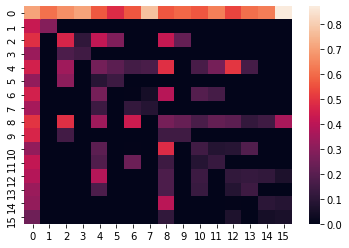

In [37]:
ax = sns.heatmap(cgr_table)